Below I present a model for identifying cancerous cells.  I did not preprocess any of the data (other than removing the first column which was a cell identification number).  All features were within the range of 1 to 10, and I removed rows in which any column had a "?" value.  This resulted in a minimum loss of data (~3% of data (20 rows)).

I kept 544 rows of the remaining data to train and validate the model (using 75% of this data to train, 25% to validate).  I used 136 rows as a holdout set to test the final model.  Data was shuffled before extracting the holdout set, maintaining a roughly equal distribution of benign/malignant cells in all sets.

The model did not perform well.  From the outset I could tell the model was overfitting and I spent most of my time trying to deal with that.  I tried Ridge, Random Forest, and SVM, but in the end report Ridge results.  If I had more time, I would have systematically chosen a better regularization parameter with looping because it appeared that there may have been a narrow window in which I could have avoided overfitting.  I was unable to find it within the 3-hr time frame.

In [1]:
#import a bunch of tools

import mglearn
import pandas as pd
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
#from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
#from sklearn.cross_validation import StratifiedKFold
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# read a database from CSV and load it into a pandas dataframe
file = '/Users/alexbaria/Desktop/Insight/breastcancerdata_trainval.csv'
data = pd.read_csv(file)
data.shape

# visualize data table
data.head(5)

,sample code number,clump thickness,uniformity cell size,uniformity cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitoses,class
0,841769,2,1,1,1,2,1.0,1,1,1,2
1,1054593,10,5,5,3,6,7.0,7,10,1,4
2,1182404,5,1,4,1,2,1.0,3,2,1,2
3,653777,8,3,4,9,3,10.0,3,3,1,4
4,527363,8,10,10,10,8,10.0,10,7,3,4


In [3]:
# drop any rows with non-numerical data
print(data.shape)
data = data.dropna()
print(data.shape)

(559, 11)
(544, 11)


In [4]:
# create X and y arrays for ML algorithms

y = data['class']
y = y-2
y = y/2
X = data.ix[:,'clump thickness':'mitoses']
print(X.shape)
print(y.shape)

# 2 = benign, 4 = malignant
y.value_counts()

(544, 9)
(544,)


0.0    358
1.0    186
Name: class, dtype: int64

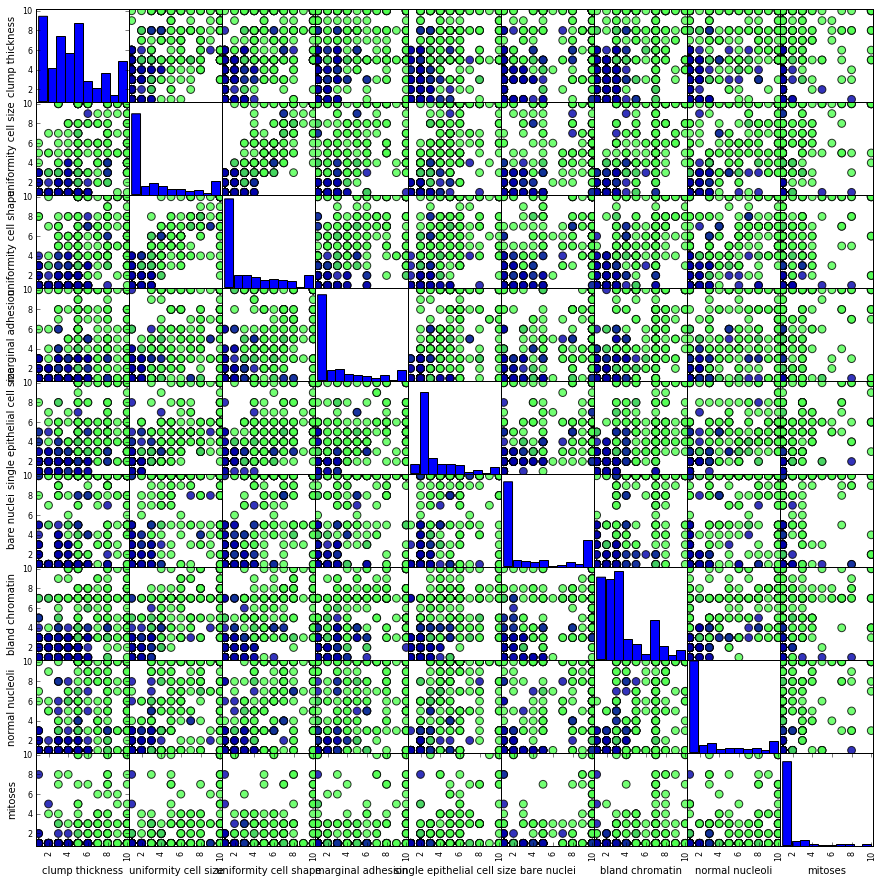

In [5]:
#visualize data
grr = pd.scatter_matrix(X, c=y, figsize=(15, 15), marker='o',
s=60, alpha=.8, cmap=mglearn.cm3)
#grr = pd.scatter_matrix(X, c=y)

The plot above makes the data appear to be fairly segregated (benign cells (blue) look to have lower values in general).

Below I will only report Ridge classification. I also tried using Random Forest classification and SVM with similar results.  All seemed to overfit, and my main challenge was trying to deal with that.

I played with the alpha parameter quite a bit here to try to deal with overfitting.  If I had more time, I would have tested it systematically looping because it seemed as though there may have been a narrow threshold in which I could have mitigated overfitting, which was at first evident here in the classification report and confusion matrix.

In [9]:
# split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0)

# I set alpha at a strange value here, although it seemed to be pretty sensitive
ridge = RidgeClassifier(alpha=30000).fit(X_train, y_train)
y_val_pred = ridge.predict(X_val)
print(classification_report(y_val, y_val_pred,target_names=["benign", "malignant"]))

# print confusion matrix
confusion = confusion_matrix(y_val, y_val_pred)
print("Confusion matrix:\n{}".format(confusion))

             precision    recall  f1-score   support

     benign       0.95      1.00      0.97        92
  malignant       1.00      0.89      0.94        44

avg / total       0.97      0.96      0.96       136

Confusion matrix:
[[92  0]
 [ 5 39]]


The ROC curve is also suspicious, as expected based on the precision and recall results.  The high AUC indicates that the probability distributions for each class are essentially non-overalapping.  

1.0


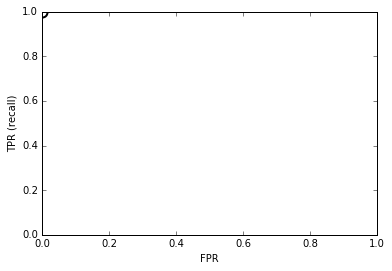

In [10]:
# plot ROC curve
y_val_prob = ridge.decision_function(X_val)
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
# find threshold closest to zero
close_zero = np.argmin(np.abs(thresholds))
plt.plot(fpr[close_zero], tpr[close_zero], 'o', markersize=10,
label="threshold zero", fillstyle="none", c='k', mew=2)
#plt.legend(loc=4)

from sklearn.metrics import roc_auc_score
ridge_auc = roc_auc_score(y_val, y_val_prob)
print(ridge_auc)

Here are the probability distributions.  Clearly non-overlapping.

(array([  8.,  21.,  18.,  21.,   8.,  10.,   3.,   1.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.]),
 array([-0.61044332, -0.58671103, -0.56297874, -0.53924644, -0.51551415,
        -0.49178186, -0.46804956, -0.44431727, -0.42058498, -0.39685269,
        -0.37312039, -0.3493881 , -0.32565581, -0.30192352, -0.27819122,
        -0.25445893, -0.23072664]),
 <a list of 16 Patch objects>)

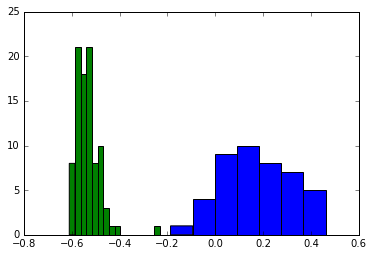

In [11]:
ypos = []
yneg = []
for i in range(0,len(y_val)):
    if list(y_val)[i]==0.0:
        yneg.append(y_val_prob[i])
    else:
        ypos.append(y_val_prob[i])
        
plt.hist(ypos,bins='auto')
plt.hist(yneg,bins='auto')

I finally wanted to check the model weights, expecting that maybe 1 feature was most responsible for distinguishing classes.  If so, I was going to try removing that feature and then seeing how the model performed...
However, it's clear from the plot below that no features really dominated the model.  Bare nuclei appeared the most important, but it didn't dominate by far.

In [12]:
# function for plotting model weights
def plot_theta(y1,ylab):
    # print the model weights
    x = np.arange(len(y1))
    plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    #ylab = X.columns[:]
    plt.barh(x,y1)
    plt.yticks(x+0.5,ylab)
    plt.ylabel("feature")
    plt.xlabel("theta")

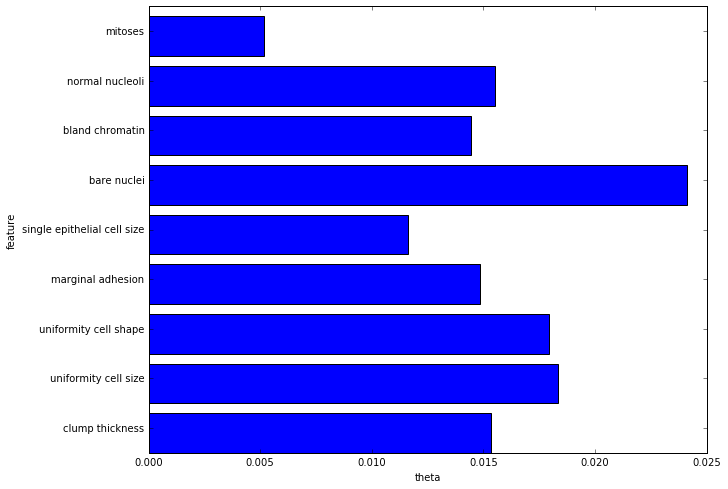

In [13]:
plot_theta(np.transpose(ridge.coef_),X.columns[:])

As I ran out of time, I decided just to go against my intuition that the model was overfitting.  Perhaps the data was simply very distinguishable with the model.  So I went ahead and checked the performance against the independent test set:

In [14]:
# read a database from CSV and load it into a pandas dataframe
file = '/Users/alexbaria/Desktop/Insight/breastcancerdata_test.csv'
data_test = pd.read_csv(file)

# drop any rows with non-numerical data
print(data_test.shape)
data_test = data_test.dropna()
print(data_test.shape)

y_test = data_test['class']
y_test = y_test-2
y_test = y_test/2
X_test = data_test.ix[:,'clump thickness':'mitoses']
print(X_test.shape)
print(y_test.shape)

# 2 = benign, 4 = malignant
y_test.value_counts()

(140, 11)
(139, 11)
(139, 9)
(139,)


0.0    86
1.0    53
Name: class, dtype: int64

In [15]:
y_test_pred = ridge.predict(X_test)
print(classification_report(y_test, y_test_pred,target_names=["benign", "malignant"]))

confusion = confusion_matrix(y_test, y_test_pred)
print("Confusion matrix:\n{}".format(confusion))

             precision    recall  f1-score   support

     benign       0.91      1.00      0.95        86
  malignant       1.00      0.83      0.91        53

avg / total       0.94      0.94      0.93       139

Confusion matrix:
[[86  0]
 [ 9 44]]


You can see from the confusion matrix that the misdiagnosed malignant are pretty high, where about 17% of the malignant cells were diagnosed as benign.  Obviously, this would not be a great model to diagnose cancerous cells.  My original suspicion that the model was overfit is pretty obvious here.